In [1]:
import pandas as pd
import numpy as np

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df.isnull().sum()

Passengers    0
dtype: int64

In [5]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


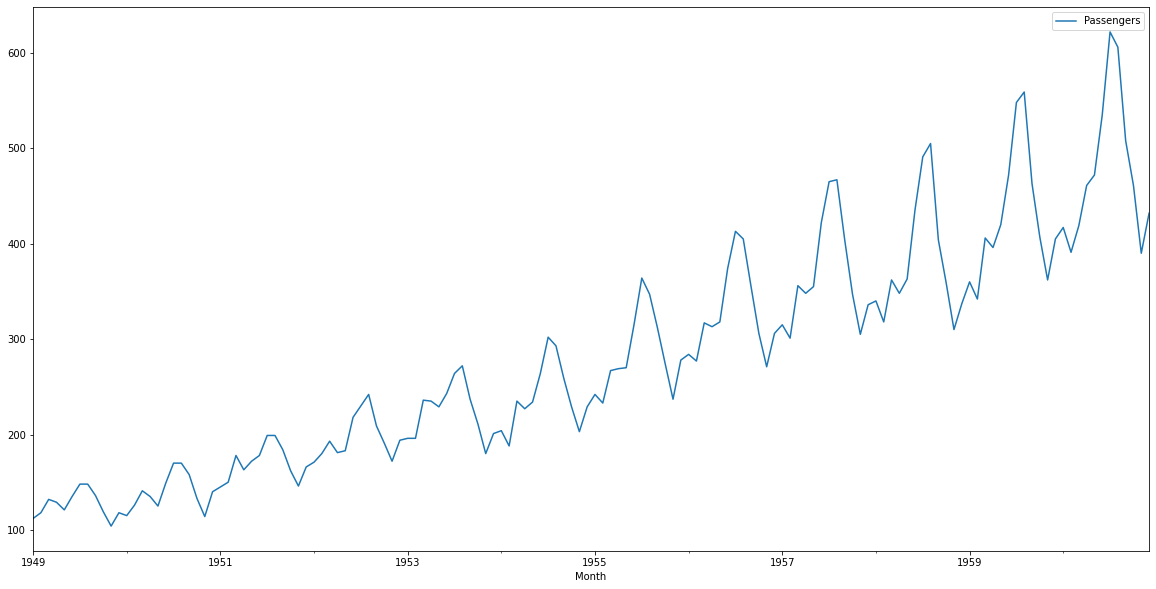

In [6]:
df.plot(figsize=(20, 10));

### EWMA

In [7]:
alpha = 0.618

Коэффициен альфа это гиперпараметр. Чем он ближе к 1, тем больший вес отдается самым последним значениям. И наборот.
При значении 1, EWMA=Price

In [8]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

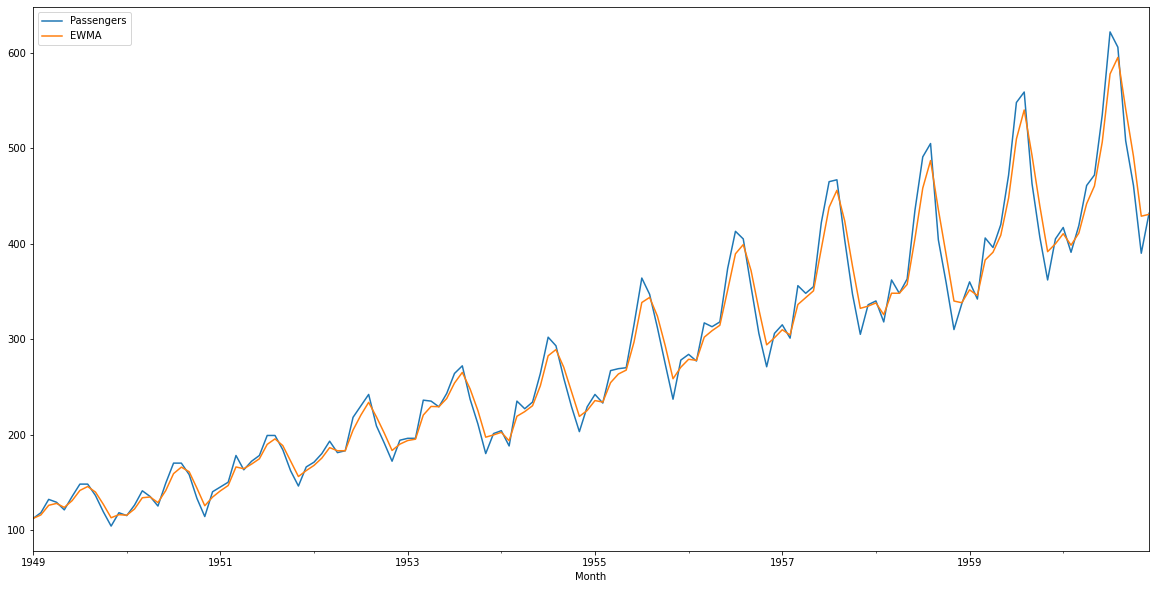

In [9]:
df.plot(figsize=(20, 10));

In [10]:
df

,Passengers,EWMA
Month,,
1949-01-01,112,112.000000
1949-02-01,118,115.708000
1949-03-01,132,125.776456
1949-04-01,129,127.768606
1949-05-01,121,123.585608
...,...,...
1960-08-01,606,595.265042
1960-09-01,508,541.335246
1960-10-01,461,491.688064


### Manual EWMA
Ручной расчет

In [11]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0: # проверка что это не первое значение
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x # вообще начальные значения инициируются нулями обычно, но тут мувинг был бы очень далеко от начальной цены
    manual_ewma.append(xhat)

df['Manual_EWMA'] = manual_ewma

In [12]:
df

,Passengers,EWMA,Manual_EWMA
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,115.708000,115.708000
1949-03-01,132,125.776456,125.776456
1949-04-01,129,127.768606,127.768606
1949-05-01,121,123.585608,123.585608
...,...,...,...
1960-08-01,606,595.265042,595.265042
1960-09-01,508,541.335246,541.335246
1960-10-01,461,491.688064,491.688064


In [13]:
df.drop(columns='Manual_EWMA', inplace=True)

## Holt's

In [22]:
# !pip install statsmodels
# !python.exe -m pip install --upgrade pip

In [23]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [24]:
ses = SimpleExpSmoothing(df['Passengers'])

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Warning что не указана частота для индексов

In [25]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

freq=None, нужно установить вручную
(https://pandas.pydata.org/docs/user_guide/timeseries.html)

In [32]:
df.index.freq = 'MS' # Month begin, M - month end. H - hourly

In [33]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [34]:
ses = SimpleExpSmoothing(df['Passengers'], initialization_method='legacy-heuristic')

In [35]:
# API тут отличается от стандартного в sklearn. тут не происходит обучение, а настраиваются гиперапараметры модели
results = ses.fit(smoothing_level=alpha, optimized=False)

In [36]:
results

In [38]:
df['SES'] = results.predict(start=df.index[0], end=df.index[-1])

In [39]:
# Поэлементное сравнение
np.allclose(df['SES'], results.fittedvalues)

True

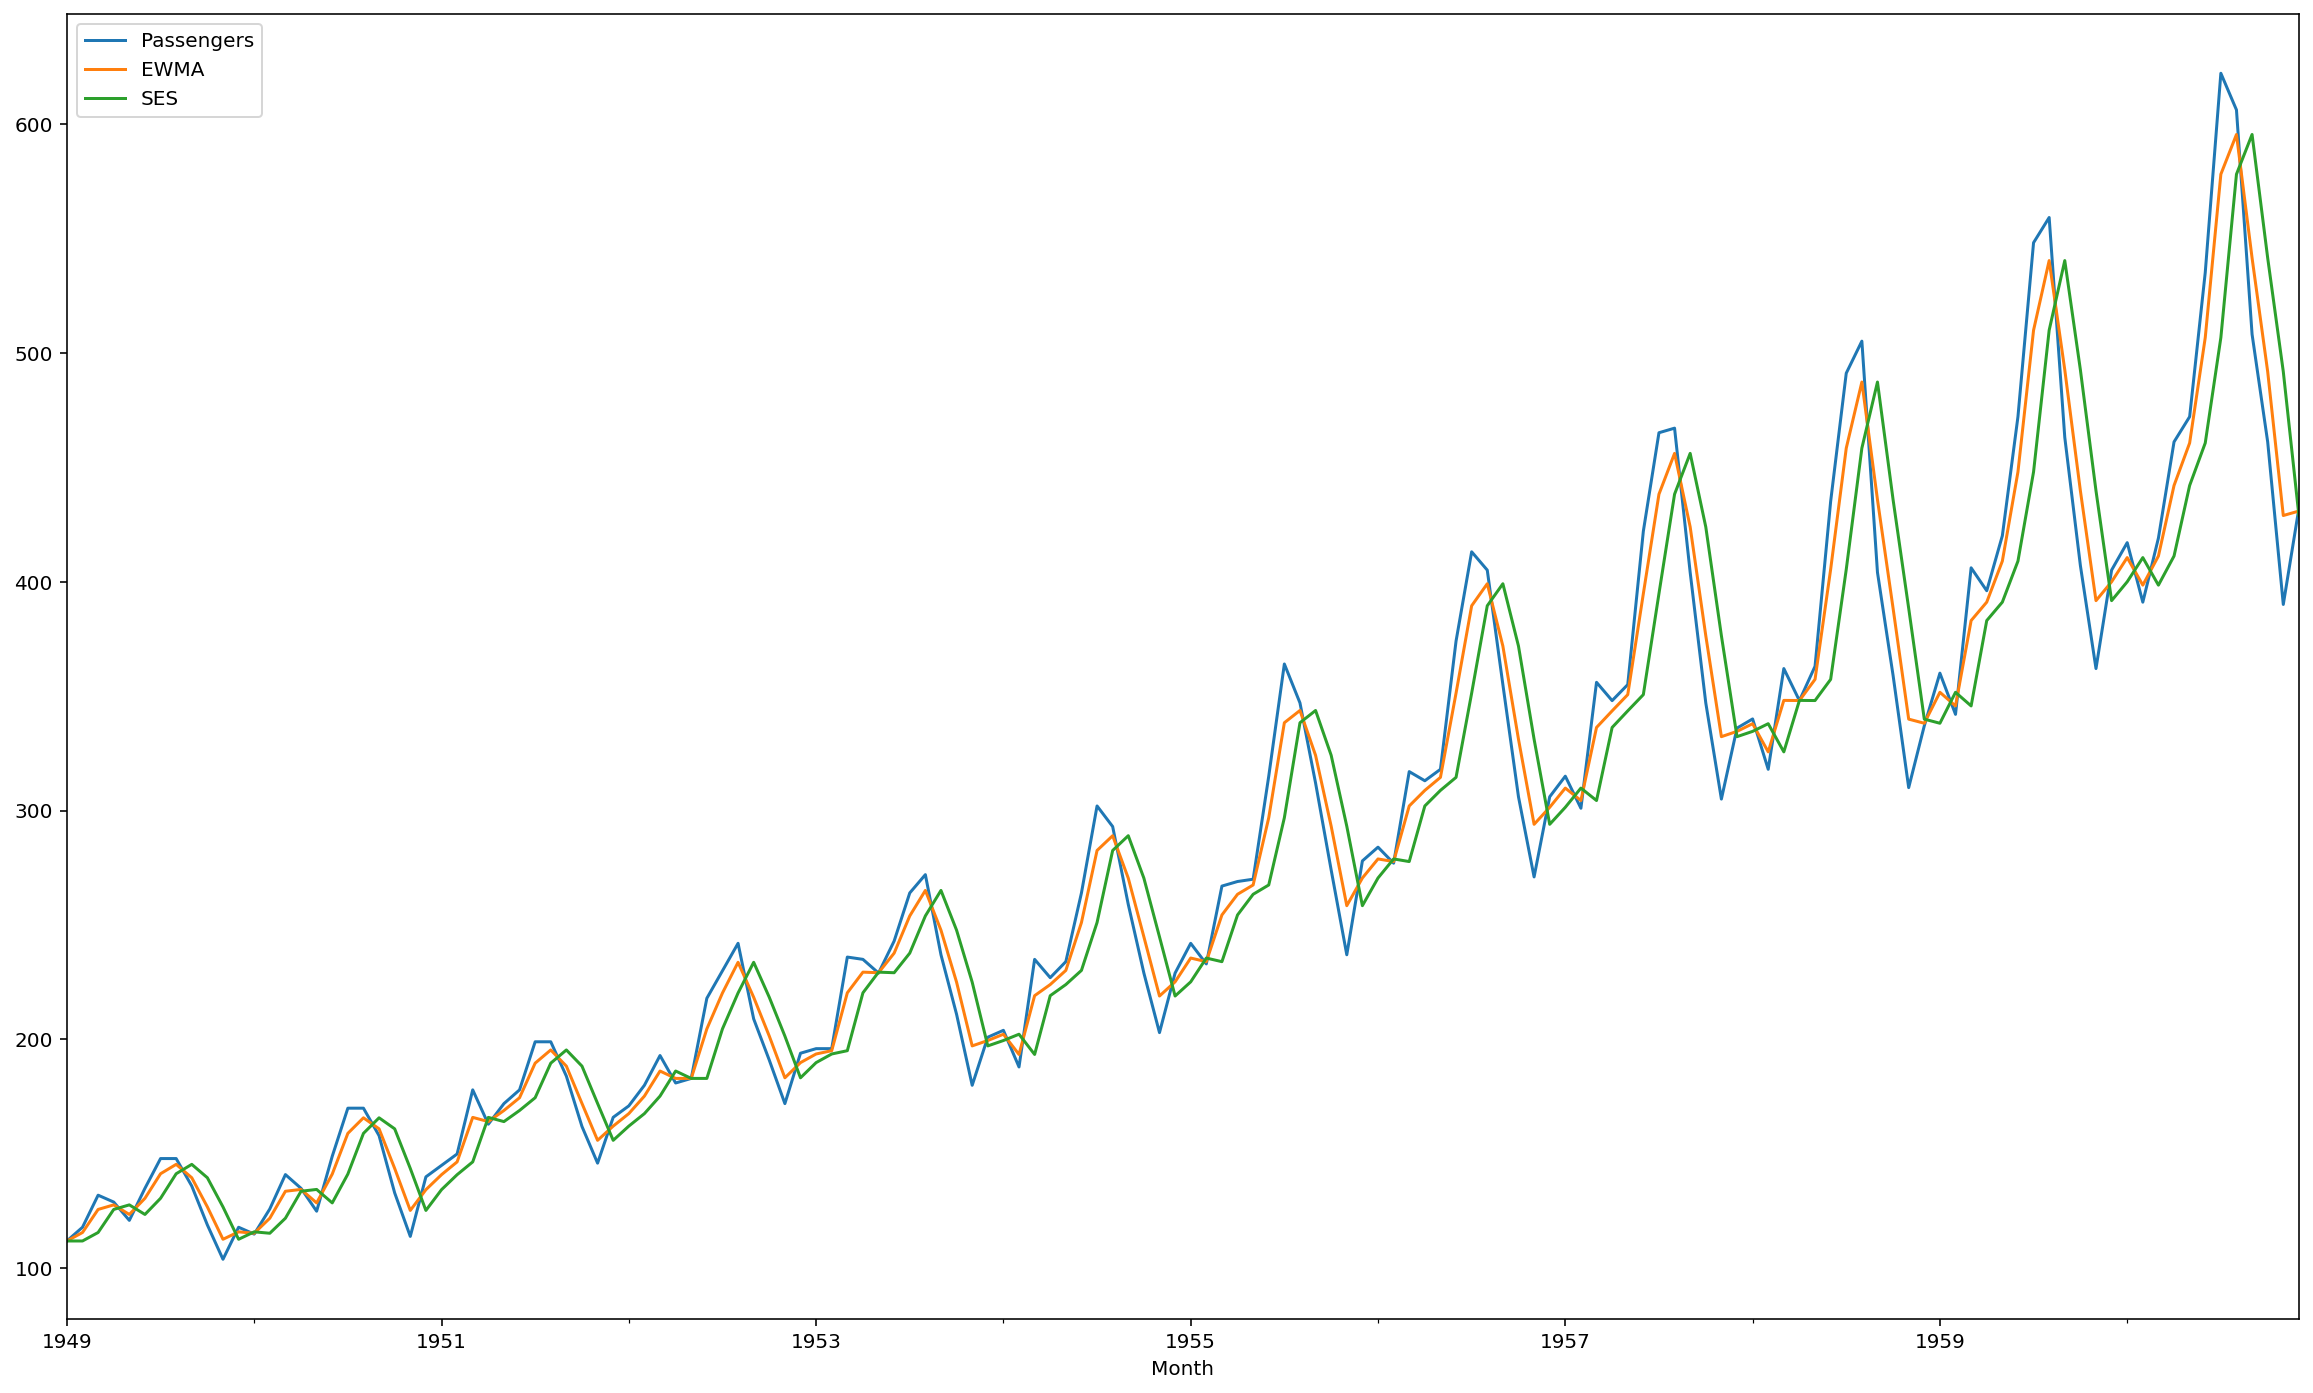

In [40]:
df.plot(figsize=(20, 12));

In [42]:
df

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,115.708000,112.000000
1949-03-01,132,125.776456,115.708000
1949-04-01,129,127.768606,125.776456
1949-05-01,121,123.585608,127.768606
...,...,...,...
1960-08-01,606,595.265042,577.898015
1960-09-01,508,541.335246,595.265042
1960-10-01,461,491.688064,541.335246


Сдвиг делать тут неправильно SES по определению запаздывает на один шаг

In [43]:
df['SES-1'] = df['SES'].shift(-1)

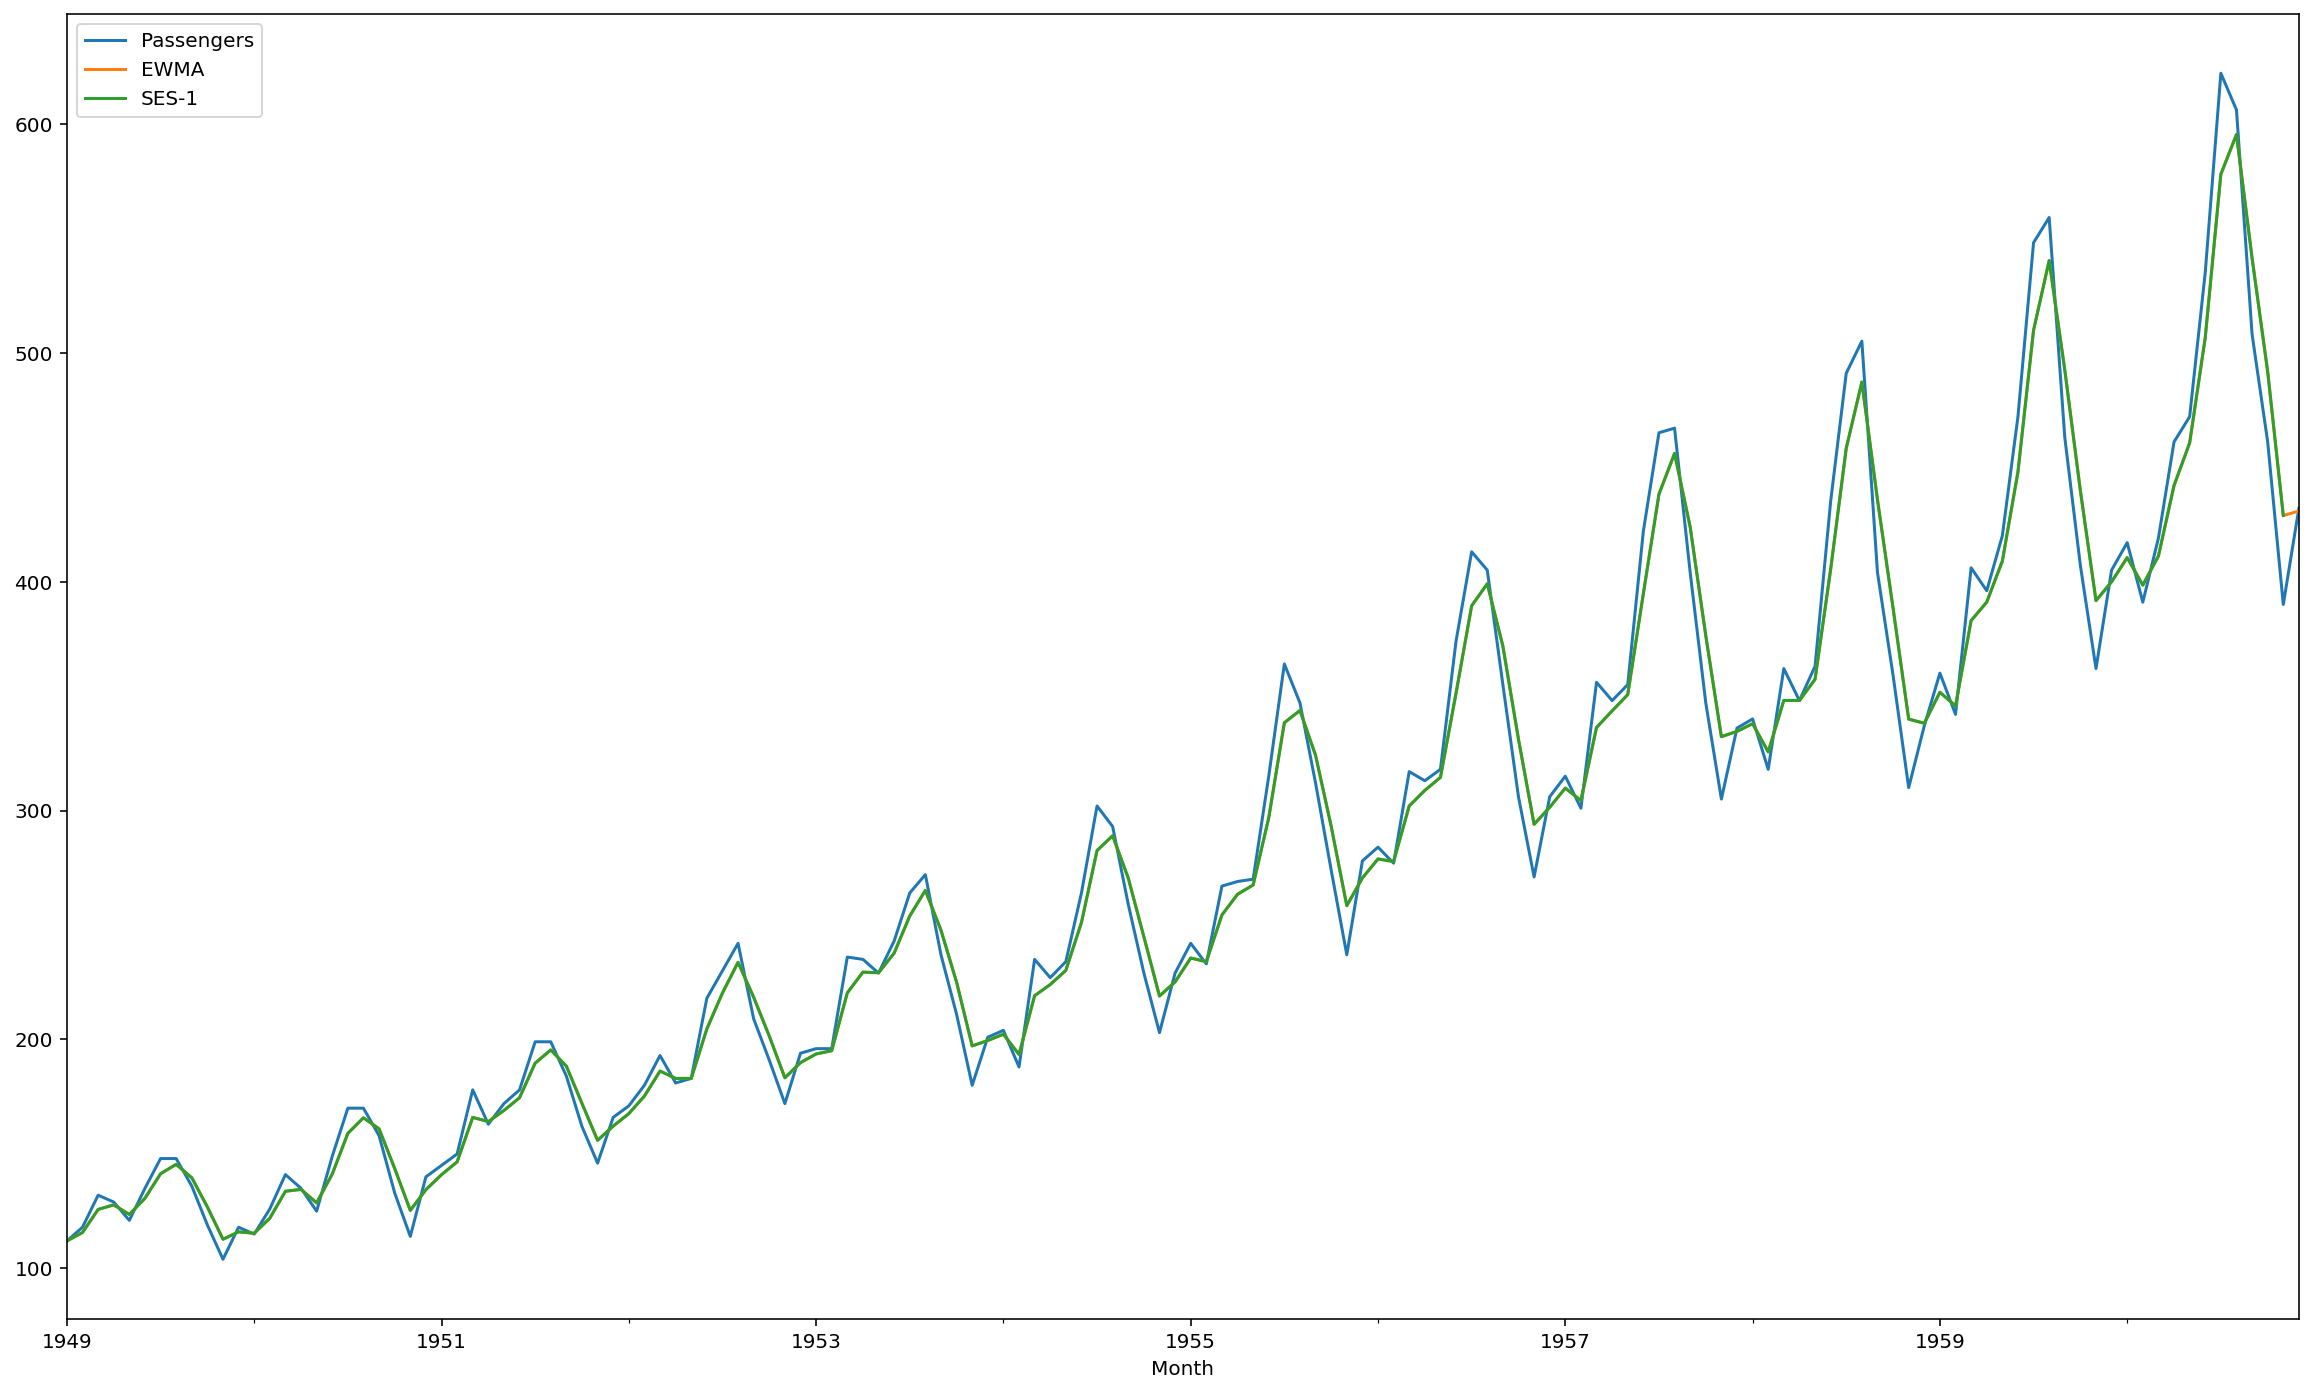

In [44]:
df[['Passengers', 'EWMA', 'SES-1']].plot(figsize=(20, 12));

Train/Test approach

In [46]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [47]:
ses = SimpleExpSmoothing(train['Passengers'], initialization_method='legacy-heuristic')
results = ses.fit() # альфа тут будет оптимизированна

In [48]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [49]:
df.loc[train_idx, 'SES_fitted'] = results.fittedvalues
df.loc[test_idx, 'SES_fitted'] = results.forecast(N_test)

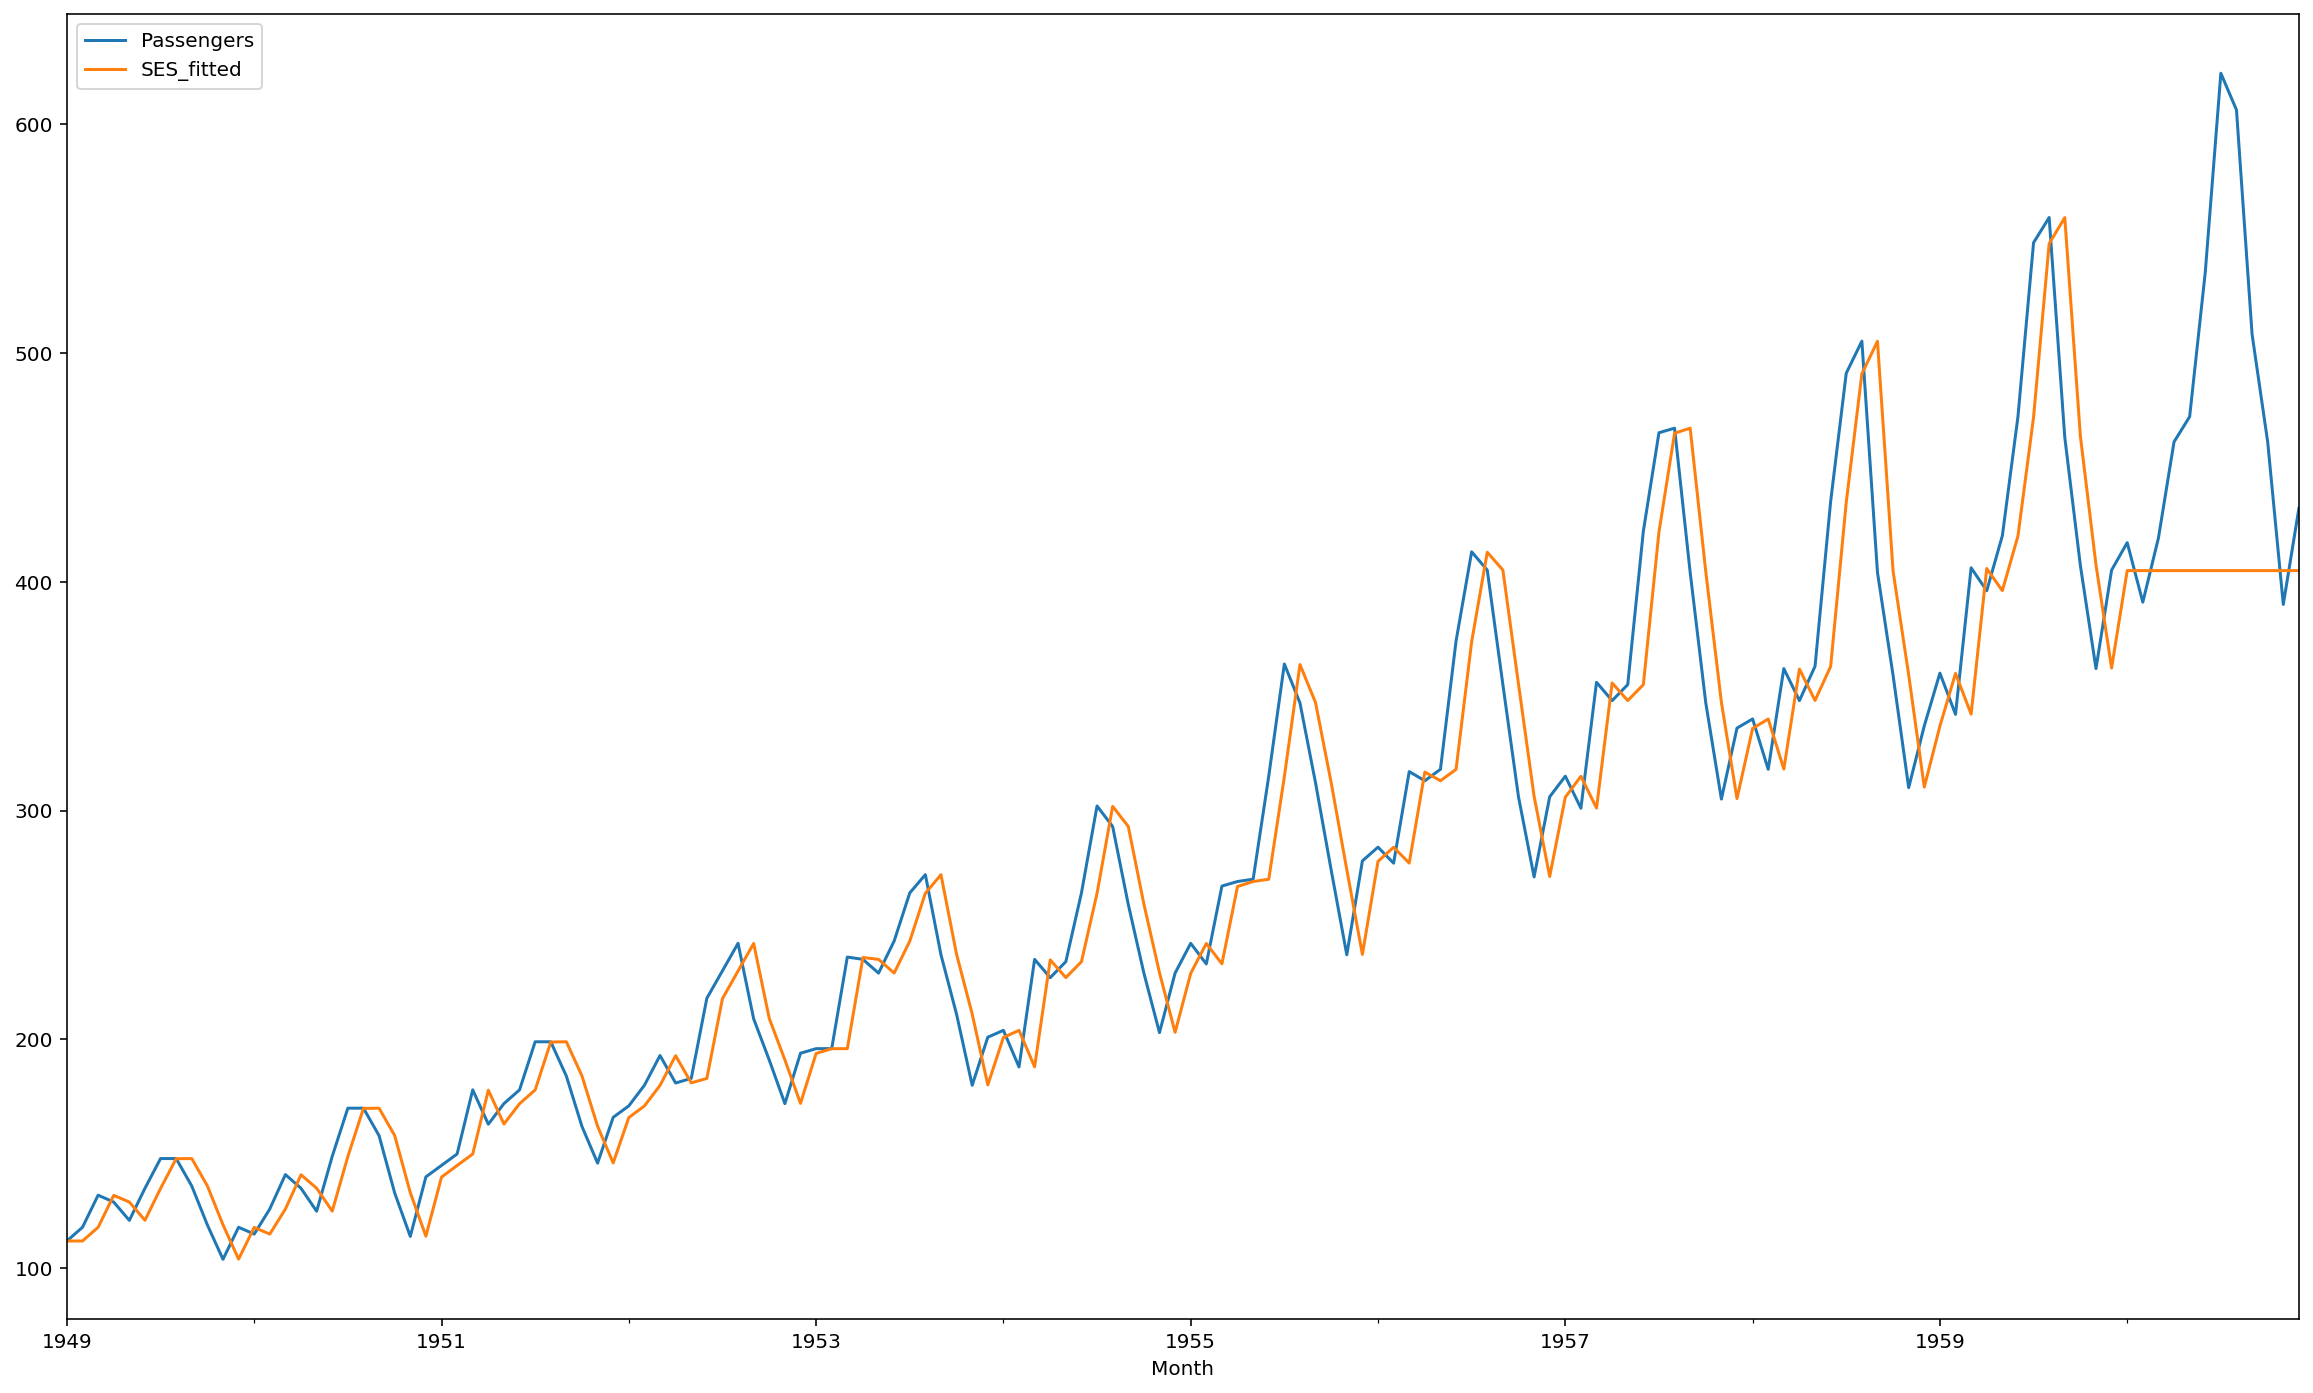

In [50]:
df[['Passengers', 'SES_fitted']].plot(figsize=(20, 12));

In [51]:
results.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

smoothing_level is alpha!

## Holt's Trend

In [56]:
from statsmodels.tsa.holtwinters import Holt

In [57]:
holt = Holt(df['Passengers'], initialization_method='legacy-heuristic')

In [58]:
results_h = holt.fit()

In [61]:
df['Holt'] = results_h.fittedvalues

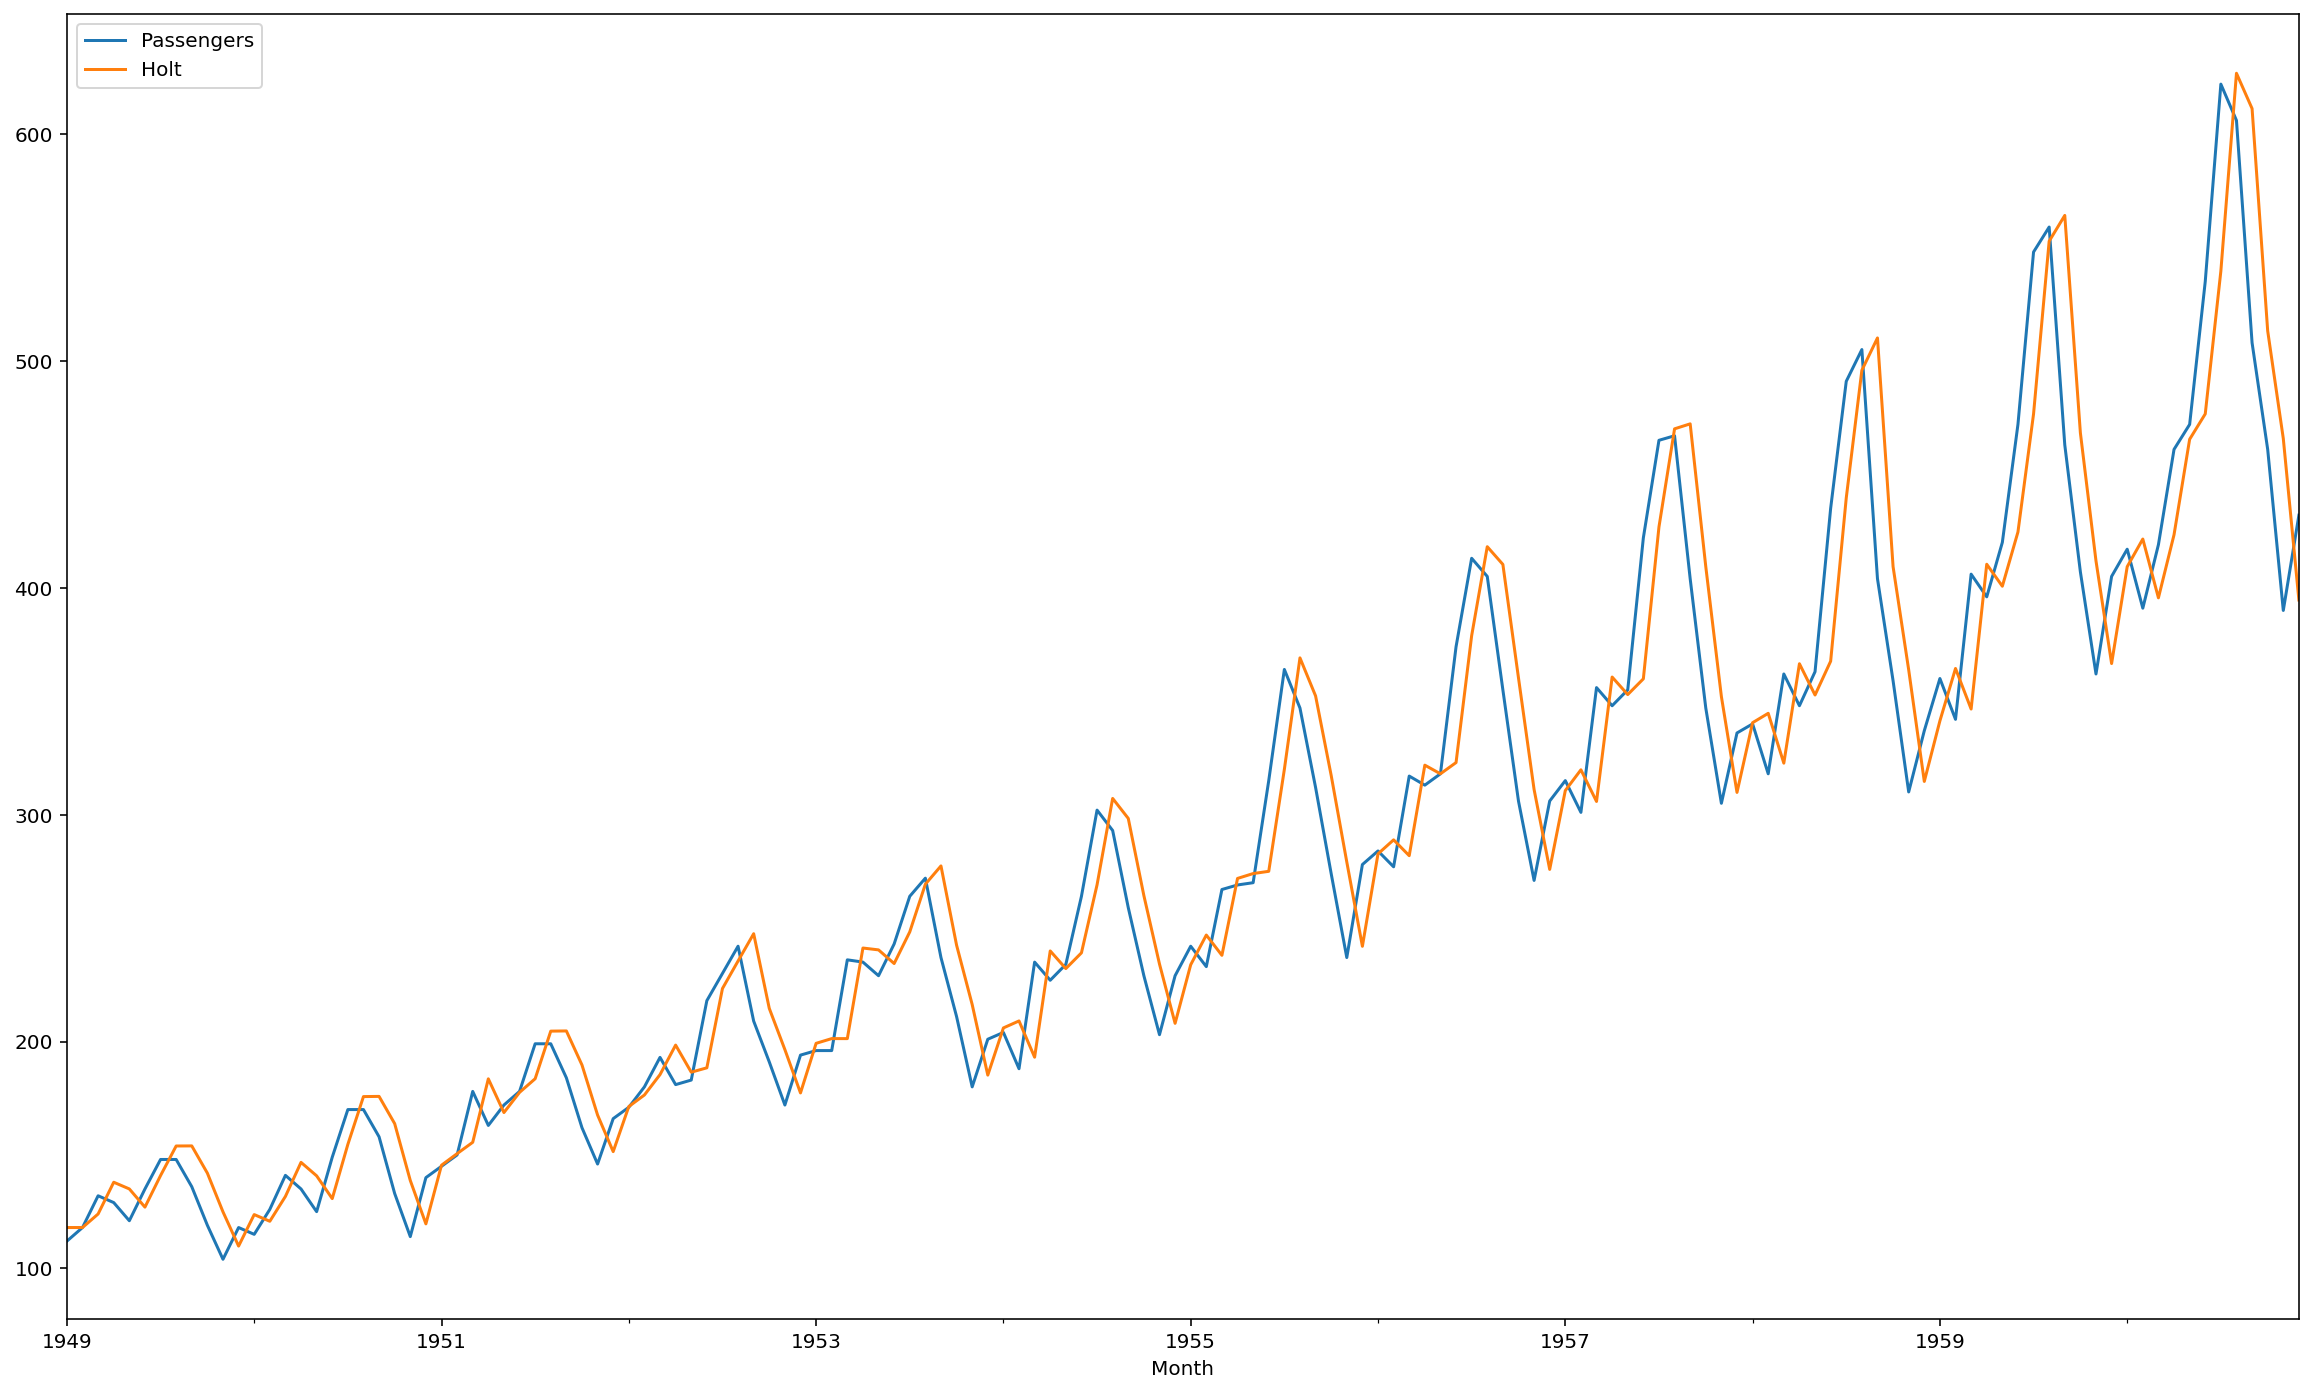

In [62]:
df[['Passengers', 'Holt']].plot(figsize=(20, 12));

In [63]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
results_h = holt.fit()

df.loc[train_idx, 'Holt'] = results_h.fittedvalues
df.loc[test_idx, 'Holt'] = results_h.forecast(N_test)

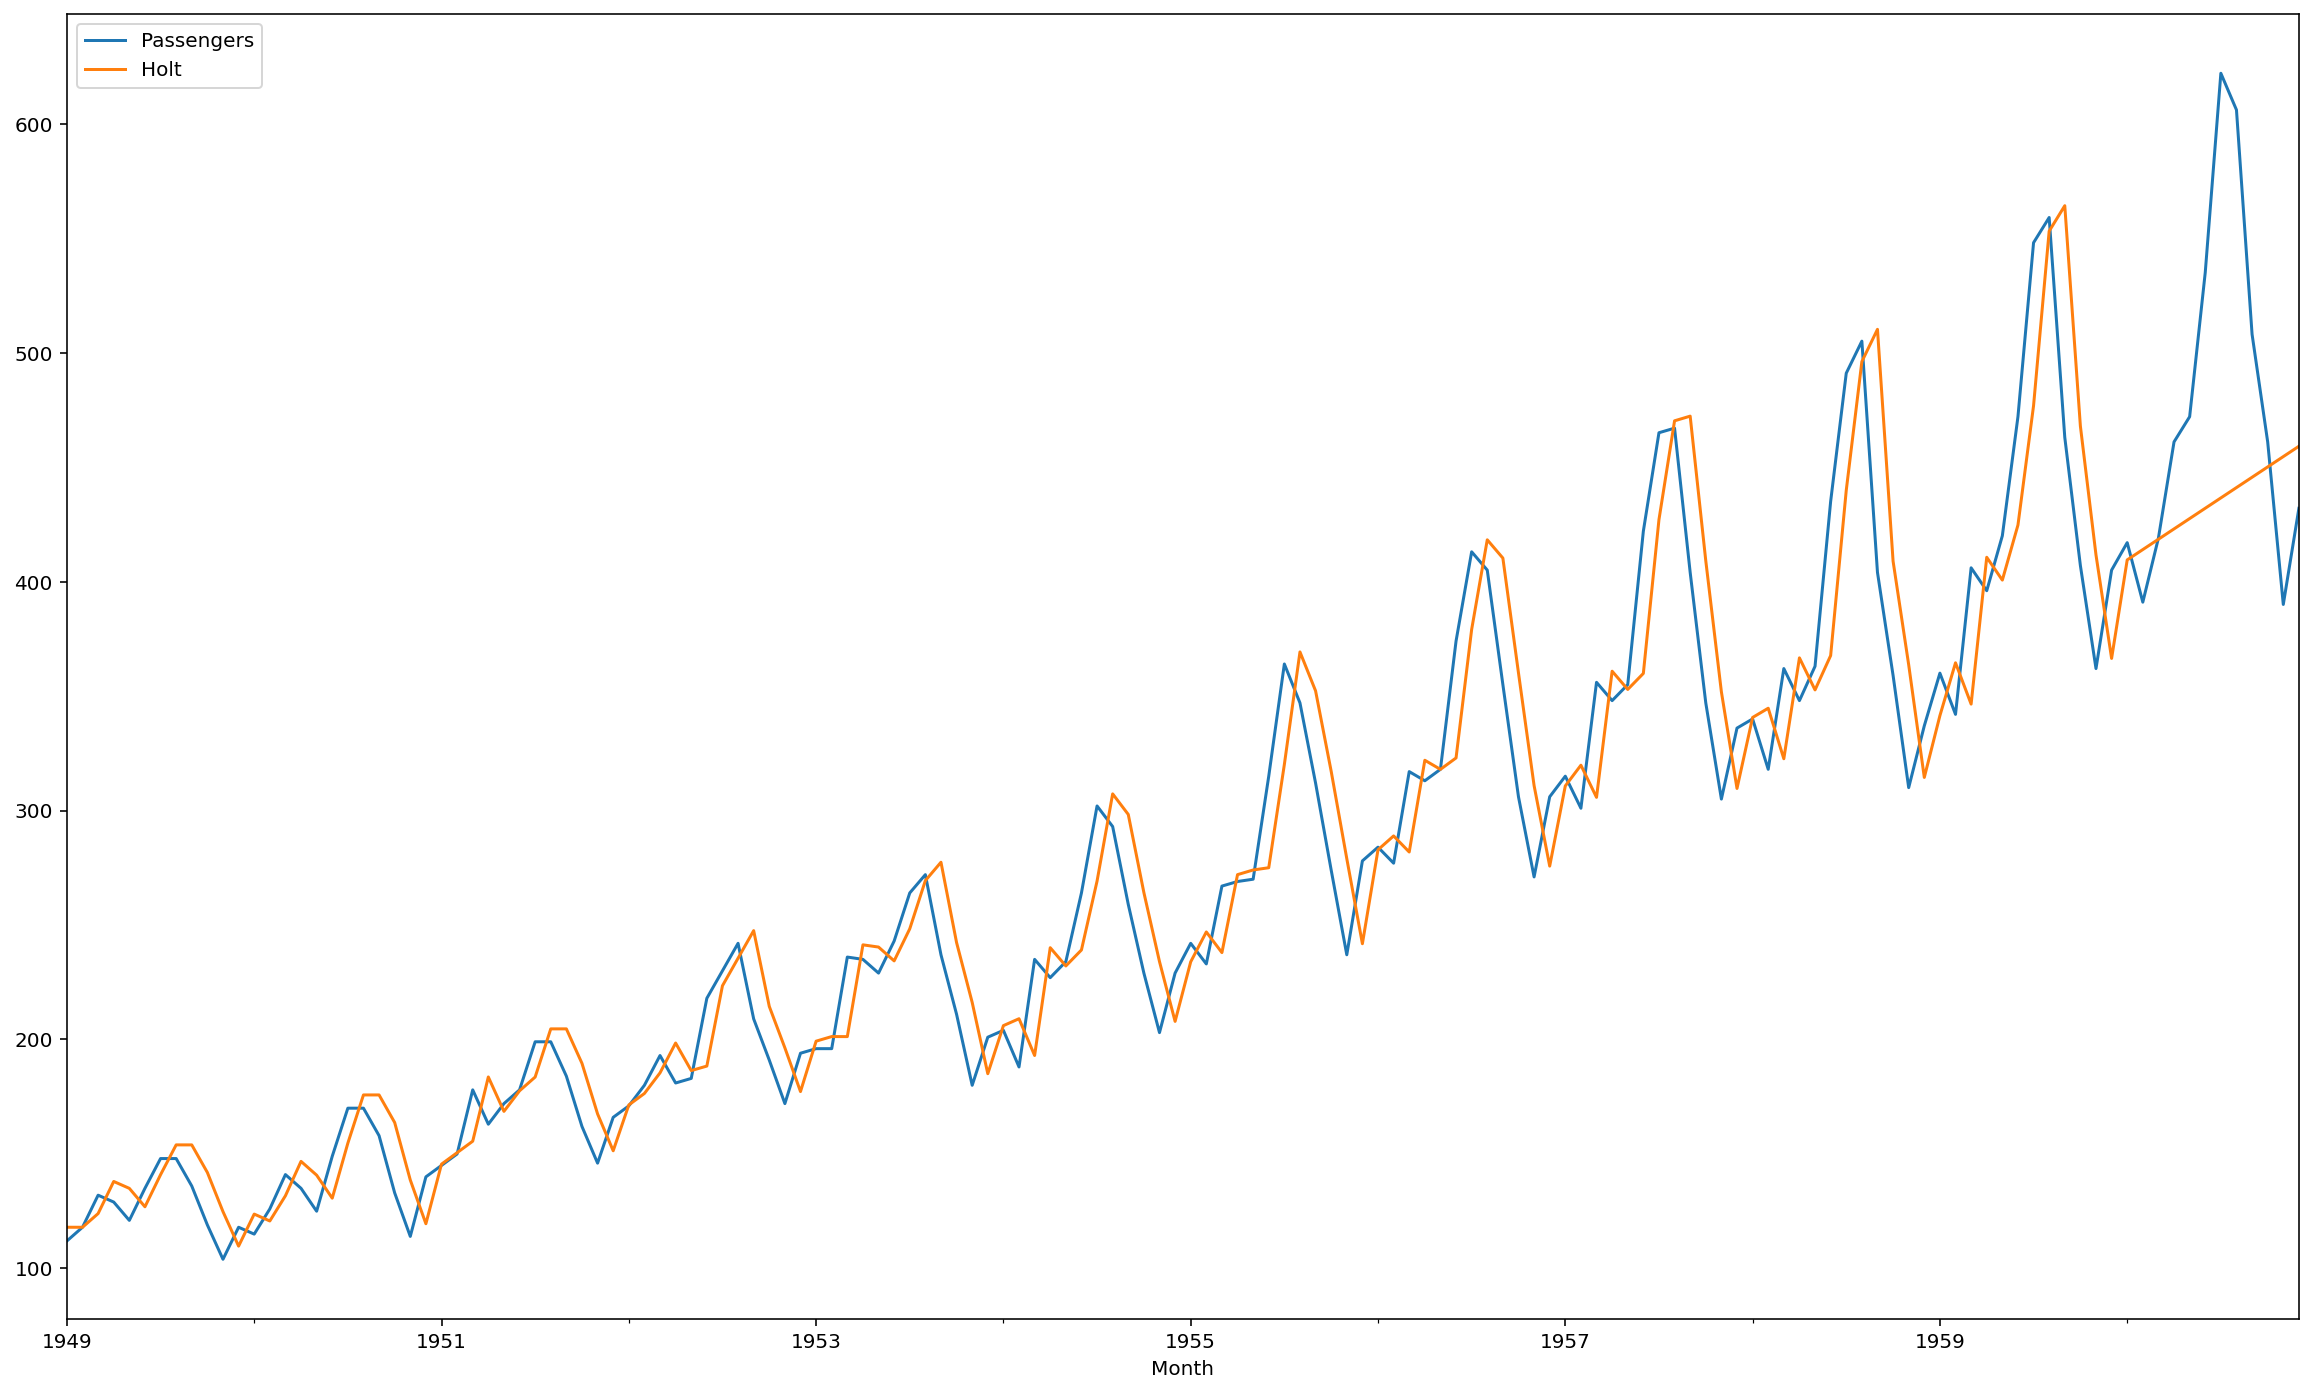

In [64]:
df[['Passengers', 'Holt']].plot(figsize=(20, 12));